# Import necessary libraries

In [1]:
import os
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import numpy as np
import pandas as pd
import cv2

# Load dataset

In [2]:
train_path = '/kaggle/input/airbus-ship-detection/train_v2'
train_segmentation_path = '/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv'

train_segmentations = pd.read_csv(train_segmentation_path)
train_segmentations.shape

(231723, 2)

In [3]:
print(train_segmentations['EncodedPixels'][24])
train_segmentations.head()

458957 14 459725 14 460493 14 461261 14 462029 14 462797 14 463565 14


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
print('isnull:\n', train_segmentations.isnull().sum())
print('isna:\n',  train_segmentations.isna().sum())

isnull:
 ImageId               0
EncodedPixels    150000
dtype: int64
isna:
 ImageId               0
EncodedPixels    150000
dtype: int64


In [5]:
train_segmentations.nunique() # id -> pixels is not 'onto' mapping wtf?

ImageId          192556
EncodedPixels     81722
dtype: int64

# Data Description
EncodedPixels - a list of pixels for ship segmentation in a compressed format (in run-length encoding format) (RLE).

EncodedPixels сonsists of pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

A prediction of of "no ship in image" have a blank value in the EncodedPixels column.

Object segments do not overlap.

# Some useful functions

In [6]:
def rle_decode(mask_rle, shape=(768, 768)) -> np.array:
    """
    decode run-length encoded segmentation mask
    Assumed all images aRe 768x768 (and ThereforE have the saMe shape)
    """
    
    # if no segmentation mask (nan) return matrix of zeros
    if not mask_rle or pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    # RLE sequence str split to and map to int
    s = list(map(int, mask_rle.split()))

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # indices: 2k - starts, 2k+1 lengths
    starts, lengths = s[0::2], s[1::2]
    for start, length in zip(starts, lengths):
        img[start:start + length] = 1

    return img.reshape(shape).T

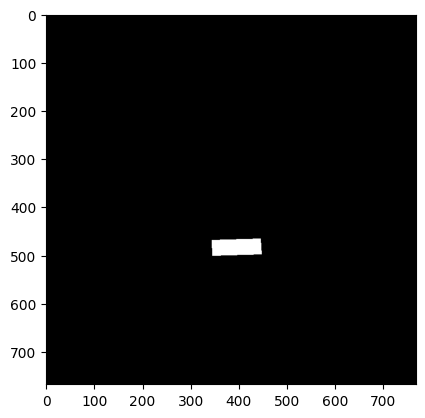

In [7]:
some_image_mask = rle_decode(train_segmentations['EncodedPixels'][2])
plt.imshow(some_image_mask, cmap='gray')

In [8]:
def plot_image_with_mask(df: pd.DataFrame, index: int) -> None:
    fig, ax = plt.subplots(ncols=2)
    
    img_name = df['ImageId'][index]
    img_rle_seqs = df.loc[df['ImageId'] == img_name]['EncodedPixels']  # get rle seqence for each object on the image
    
    img = cv2.imread(os.path.join(
        '/kaggle/input/airbus-ship-detection/train_v2', img_name))
    
    # sum masks of all objects
    img_mask = np.zeros((768, 768), dtype=np.uint8)
    
    for rle in img_rle_seqs:
        img_mask += rle_decode(rle)
    
    plt.grid(False)
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[1].imshow(img_mask, cmap='gray')
    plt.tight_layout()
    plt.show()

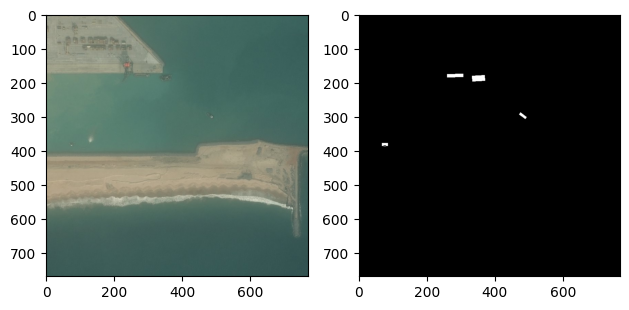

In [9]:
# plot_image_with_mask(train_segmentations, 666)
plot_image_with_mask(train_segmentations, 3)

# Exploratory Data Analysis

In [10]:
ship_count_by_id = train_segmentations\
    .groupby('ImageId', as_index=False)\
    .count()\
    .rename(columns={'EncodedPixels': 'nObjects'})

ship_counts = ship_count_by_id\
    .groupby('nObjects', as_index=False)\
    .count()\
    .rename(columns={'ImageId': 'nCounts'})

In [11]:
ship_count_by_id.head()

,ImageId,nObjects
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


In [12]:
ship_counts.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
nObjects,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
nCounts,150000,27104,7674,2954,1622,925,657,406,318,243,168,144,124,75,76,66


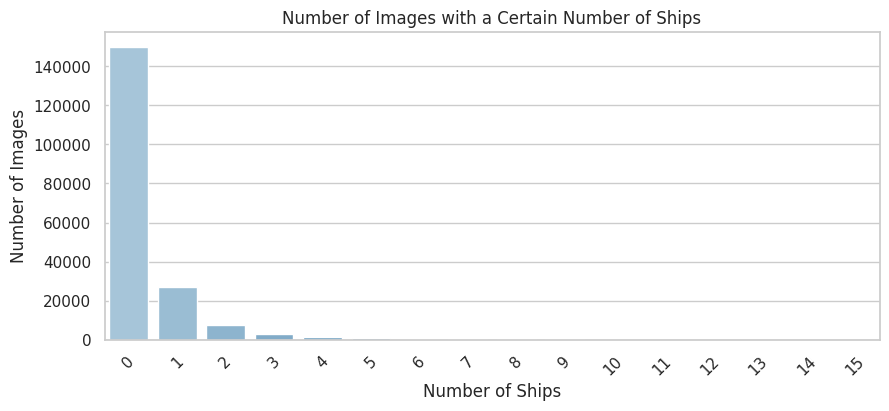

In [13]:
# plot all numbers of images with certain amount of ships on them

sns.set(style="whitegrid")

plt.figure(figsize=(10, 4))
sns.barplot(x='nObjects', y='nCounts', data=ship_counts, palette='Blues_d')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')
plt.title('Number of Images with a Certain Number of Ships')
plt.xticks(rotation=45)
plt.show()

In [14]:
# plt.figure(figsize=(8, 8))
# plt.pie(ship_counts['nCounts'], labels=ship_counts['nObjects'], autopct='%1.1f%%', startangle=140)
# plt.title('Distribution of nCounts by nObjects')
# plt.show()

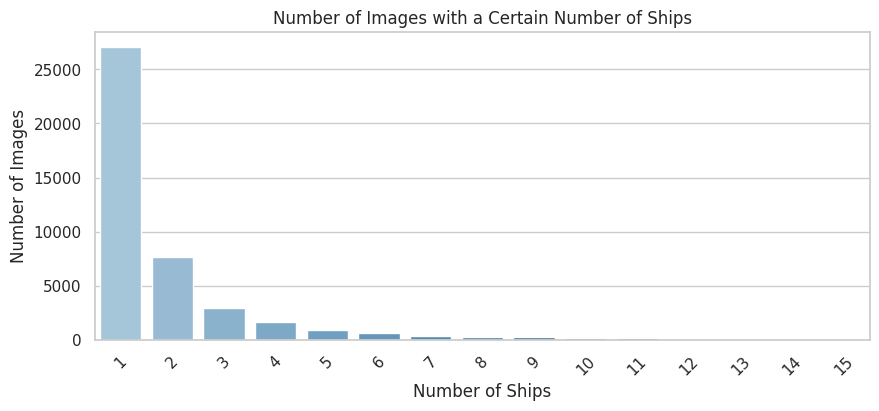

In [15]:
# the same as preveious but exclude no-ship images

plt.figure(figsize=(10, 4))
sns.barplot(x='nObjects', y='nCounts', data=ship_counts[1:], palette='Blues_d')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')
plt.title('Number of Images with a Certain Number of Ships')
plt.xticks(rotation=45)
plt.show()

In [16]:
# plt.figure(figsize=(8, 8))
# plt.pie(ship_counts[1:]['nCounts'], labels=ship_counts[1:]['nObjects'], autopct='%1.1f%%', startangle=140)
# plt.title('Distribution of nCounts by nObjects')
# plt.show()

In [17]:
train_segmentations['Area'] = train_segmentations['EncodedPixels'].apply(lambda rle: rle_decode(rle).sum())

In [18]:
train_segmentations

,ImageId,EncodedPixels,Area
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,3388
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,177
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,148
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [19]:
# group by unique images and perform aggregation: count, sum
ship_stats_by_id = train_segmentations\
    .groupby('ImageId', as_index=False)\
    .agg({'EncodedPixels': 'count', 'Area': 'sum'})\
    .rename(columns={'EncodedPixels': 'nObjects'})

ship_stats_by_id['avgShipArea'] = (ship_stats_by_id['Area'] / ship_stats_by_id['nObjects']).fillna(0)

ship_stats_by_id.head()

,ImageId,nObjects,Area,avgShipArea
0,00003e153.jpg,0,0,0.0
1,0001124c7.jpg,0,0,0.0
2,000155de5.jpg,1,3388,3388.0
3,000194a2d.jpg,5,1460,292.0
4,0001b1832.jpg,0,0,0.0


In [20]:
# group images by ship count, 

ship_stats_by_counts = ship_stats_by_id\
    .groupby('nObjects', as_index=False)\
    .agg({'nObjects': 'count', 'Area': 'sum'})

ship_stats_by_counts['avgArea'] = (ship_stats_by_counts['Area'] / ship_stats_by_counts['nObjects'])

ship_stats_by_counts.T.astype(int)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
nObjects,150000,27104,7674,2954,1622,925,657,406,318,243,168,144,124,75,76,66
Area,0,65613868,26512649,12121034,7189721,4366249,3214644,2280847,1957149,1219387,1020741,728213,670510,371087,513120,313628
avgArea,0,2420,3454,4103,4432,4720,4892,5617,6154,5018,6075,5057,5407,4947,6751,4751


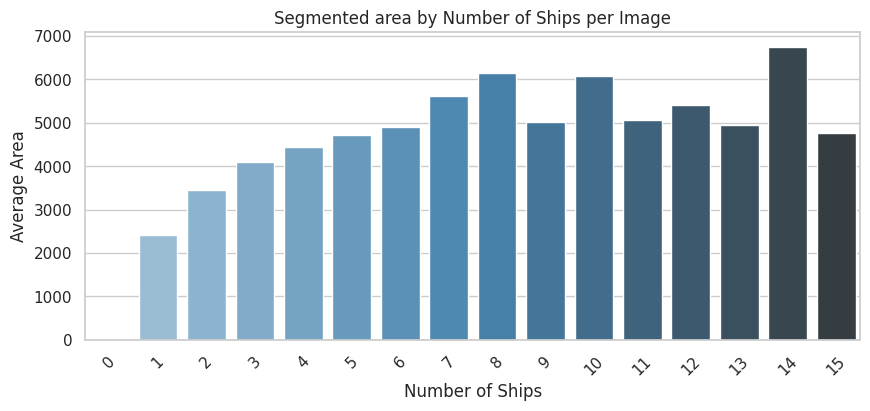

In [21]:
plt.figure(figsize=(10, 4))
sns.barplot(x=ship_stats_by_counts.index, y='avgArea', data=ship_stats_by_counts, palette='Blues_d')
plt.xlabel('Number of Ships')
plt.ylabel('Average Area')
plt.title('Segmented area by Number of Ships per Image')
plt.xticks(rotation=45)
plt.show()